In [1]:
# case specification
dafiCase = '../case-1/'
sampleId = 50
timeDir = 100

In [2]:
#############################################################################
# load data
#############################################################################
# plot flow field
import os
import numpy as np
import fluidfoam as ff

##############################################################################
foamCase = os.path.join(dafiCase, 'results_ensemble', f'sample_{sampleId}')
U = ff.readvector(foamCase, f'{timeDir:g}', 'U')
theta1 = ff.readscalar(foamCase, f'{timeDir:g}', 'theta1')
theta2 = ff.readscalar(foamCase, f'{timeDir:g}', 'theta2')
theta3 = ff.readscalar(foamCase, f'{timeDir:g}', 'theta3')
theta4 = ff.readscalar(foamCase, f'{timeDir:g}', 'theta4')
theta5 = ff.readscalar(foamCase, f'{timeDir:g}', 'theta5')
theta6 = ff.readscalar(foamCase, f'{timeDir:g}', 'theta6')
g1 = ff.readscalar(foamCase, f'{timeDir:g}', 'g1')
g2 = ff.readscalar(foamCase, f'{timeDir:g}', 'g2')
g3 = ff.readscalar(foamCase, f'{timeDir:g}', 'g3')
g4 = ff.readscalar(foamCase, f'{timeDir:g}', 'g4')
print('Ux, min, max', U[0, :].min(), U[0, :].max())
print('Uy, min, max', U[1, :].min(), U[1, :].max())
print('Uz, min, max', U[2, :].min(), U[2, :].max())
print('theta1, min, max', theta1.min(), theta1.max())
print('theta2, min, max', theta2.min(), theta2.max())
print('theta3, min, max', theta3.min(), theta3.max())
print('theta4, min, max', theta4.min(), theta4.max())
print('theta5, min, max', theta5.min(), theta5.max())
print('theta6, min, max', theta6.min(), theta6.max())
x, y, z = ff.readmesh(foamCase)

theta = np.concatenate(
    (theta1.reshape(-1, 1), theta2.reshape(-1, 1), theta3.reshape(-1, 1),
     theta4.reshape(-1, 1), theta5.reshape(-1, 1), theta6.reshape(-1, 1)),
    axis=1)

g = np.concatenate(
    (g1.reshape(-1, 1), g2.reshape(-1, 1), g3.reshape(-1, 1), g4.reshape(
        -1, 1)),
    axis=1)

np.savetxt(
    f'theta-range-{sampleId}.csv',
    np.concatenate(
        (theta.min(axis=0).reshape(-1, 1), theta.max(axis=0).reshape(-1, 1)),
        axis=1),
    delimiter=',')

print(theta)

Reading file ../case-1/results_ensemble\sample_50\100\U
Reading file ../case-1/results_ensemble\sample_50\100\theta1
Reading file ../case-1/results_ensemble\sample_50\100\theta2
Reading file ../case-1/results_ensemble\sample_50\100\theta3
Reading file ../case-1/results_ensemble\sample_50\100\theta4
Reading file ../case-1/results_ensemble\sample_50\100\theta5
Reading file ../case-1/results_ensemble\sample_50\100\theta6
Reading file ../case-1/results_ensemble\sample_50\100\g1
Reading file ../case-1/results_ensemble\sample_50\100\g2
Reading file ../case-1/results_ensemble\sample_50\100\g3
Reading file ../case-1/results_ensemble\sample_50\100\g4
Ux, min, max 0.000940639 1.32315
Uy, min, max -0.00129902 0.00181287
Uz, min, max -0.00129902 0.00181287
theta1, min, max 0.00334674 7.52324
theta2, min, max -7.52324 -0.00334674
theta3, min, max -0.20568 0.203749
theta4, min, max -0.0679166 0.0685601
theta5, min, max -28.2996 -5.60033e-06
theta6, min, max -1.4e-14 0.0127022
Reading file ../case-1/

In [3]:
################################################################
# load neural network
import time
import tensorflow as tf
import numpy as np
import os

# set threads of tf = 1
os.environ["TF_NUM_INTEROP_THREADS"] = "1"  #
os.environ["TF_NUM_INTRAOP_THREADS"] = "1"  #
# set threads of openmp = 1
os.environ["OMP_NUM_THREADS"] = "1"  #

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

f = open('python_module.log', 'w+')
print('_________________________________________________________________',
      file=f)
print('Computing function of scalar invariants from Python module', file=f)
print('Tensorflow version', tf.__version__, file=f)
print('_________________________________________________________________',
      file=f)

# tf.keras.backend.clear_session()
# tf.config.threading.set_intra_op_parallelism_threads(2)
# load model

model_path = '../NN-pre-train/nn_model_235.h5'
model = tf.keras.models.load_model(model_path)
# model.summary()

# load weights
# get weights flatten
weights_flatten = np.loadtxt(
    os.path.join(dafiCase, 'results_ensemble', f'sample_{sampleId}',
                 'nn_weights_flatten.dat'))
# weights_flatten = np.loadtxt('/home/wuct/dafi/pehills-NN-closure/inputs/w.0')

# get model shape
shapes = []
for iw in model.trainable_variables:
    shapes.append(iw.shape)

# shapes to sizes
sizes = []
for shape in shapes:
    isize = 1
    for ishape in shape:
        isize *= ishape
    sizes.append(isize)

# reshape weights
w_reshaped = []
i = 0
for shape, size in zip(shapes, sizes):
    w_reshaped.append(weights_flatten[i:i + size].reshape(shape))
    i += size
    # print(w_reshaped)
model.set_weights(w_reshaped)

print(model.get_weights(), file=f)
print('Neural-network weights loaded successfully', file=f)


def ml_func(array):
    # print(np.shape(array))
    array_scaled = np.zeros_like(array)
    t12 = np.loadtxt(f'theta-range-{sampleId}.csv', delimiter=',')

    array_scaled[:, 0] = (array[:, 0] - t12[0, 0]) / (t12[0, 1] - t12[0, 0])
    array_scaled[:, 1] = (array[:, 1] - t12[1, 0]) / (t12[1, 1] - t12[1, 0])
    array_scaled[:, 2] = (array[:, 2] - t12[1, 0]) / (t12[1, 1] - t12[1, 0])
    array_scaled[:, 3] = (array[:, 3] - t12[1, 0]) / (t12[1, 1] - t12[1, 0])
    array_scaled[:, 4] = (array[:, 4] - t12[1, 0]) / (t12[1, 1] - t12[1, 0])
    array_scaled[:, 5] = (array[:, 5] - t12[1, 0]) / (t12[1, 1] - t12[1, 0])

    g_ = model(array_scaled, training=False)

    g = np.array(g_).reshape(-1, 5).astype('double')
    # print(g)
    scale = [1.e-1, 1.e-3, 1.e-3, 1.e-3, 0]  # [0.1,0.001,0.001,0.001]
    init = [-0.09, 0, 0, 0, 0]  # [-0.09,1e-4,1e-4,1e-4]
    for i in range(g.shape[1]):
        # scale[i]*g[:, i] + (1.0 - scale[i])*init[i]
        g[:, i] = scale[i] * g[:, i] + init[i]

    # print(g)

    for i in range(g.shape[0]):
        for j in range(g.shape[1]):
            if j == 0 and g[i, j] > -0.0:
                g[i, j] = -0.0
            # if j == 1 and g[i, j] > 0.01: g[i, j] = 0.01
            # if j == 2 and g[i, j] < -0.01: g[i, j] = -0.01
            # if j == 3 and g[i, j] < -0.01: g[i, j] = -0.01
    # print('using tensorflow time', time.time() - t1)

    return g


def g1_nn(theta_):
    g_ = ml_func(theta_)
    # perturbed_data = g_[:, 0] + np.random.normal(0, 1e-8, np.shape(g_[:, 0]))
    return g_[:, 0]  #+ perturbed_data


def g1_SHIH(theta_):
    if (theta_[:, 0] < 0).any():
        print('x1 need be larger than zero')
        return
    if (theta_[:, 1] > 0).any():
        print('x2 need be less than zero')
        return
    return -(2.0 / 3.0) / (1.25 + np.sqrt(2 * theta_[:, 0]) +
                           0.9 * np.sqrt(-2 * theta_[:, 1]))


def g1_Shih(x1, x2):
    if (x1 < 0).any():
        print('x1 need be larger than zero')
        return
    if (x2 > 0).any():
        print('x2 need be less than zero')
        return
    return -(2.0 / 3.0) / (1.25 + np.sqrt(2 * x1) + 0.9 * np.sqrt(-2 * x2))


def g2_Shih(x1):
    if (x1 < 0).any():
        print('x1 need be larger than zero')
        return
    return 7.5 / (1000 + np.power(2 * x1, 1.5))


def g3_Shih(x1):
    if (x1 < 0).any():
        print('x1 need be larger than zero')
        return
    return 1.5 / (1000 + np.power(2 * x1, 1.5))


def g4_Shih(x1):
    if (x1 < 0).any():
        print('x1 need be larger than zero')
        return
    return -9.5 / (1000 + np.power(2 * x1, 1.5))

c:\Python311\Lib\site-packages\tensorflow\python\debug\cli\debugger_cli_common.py:19: DeprecationWarning: module 'sre_constants' is deprecated
  import sre_constants


In [ ]:
##########################################################################################
# PFI explnanation for NN model and SHIH function
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
import numpy as np

depth = 60
rfr_g1_NN = RandomForestRegressor(max_depth=depth)
rfr_g1_SHIH = RandomForestRegressor(max_depth=depth)
rfr_g1_NN.fit(theta, g[:, 0])
rfr_g1_SHIH.fit(theta, g1_SHIH(theta))

error_NN = np.abs(rfr_g1_NN.predict(theta) - g[:, 0])
error_SHIH = np.abs(rfr_g1_SHIH.predict(theta) - g1_SHIH(theta))
print('error   NN, min, max, mean', error_NN.min(), error_NN.max(),
      error_NN.mean())
print('error Shih, min, max, mean', error_SHIH.min(), error_SHIH.max(),
      error_SHIH.mean())

results_pfi_NN = permutation_importance(rfr_g1_NN,
                                        theta,
                                        g[:, 0],
                                        n_repeats=300,
                                        random_state=0)

results_pfi_SHIH = permutation_importance(rfr_g1_SHIH,
                                          theta,
                                          g1_SHIH(theta),
                                          n_repeats=300,
                                          random_state=0)


In [ ]:
##########################################################################################
# SHAP explnanation for NN model
import shap

explainer = shap.KernelExplainer(g1_nn, theta)
shap_values = explainer.shap_values(theta, nsamples=20)
np.savetxt('Shap-values-NN.csv', shap_values, delimiter=',')


In [ ]:
##########################################################################################
# SHAP explnanation for SHIH function
import shap

explainer = shap.KernelExplainer(g1_SHIH, theta)
shap_values = explainer.shap_values(theta, nsamples=20)
np.savetxt('Shap-values-Shih.csv', shap_values, delimiter=',')


In [ ]:
import numpy as np
import shap

theta_range = np.loadtxt(f'theta-range-{sampleId}.csv', delimiter=',')
theta_1_, theta_2_, theta_3_, theta_4_, theta_5_, theta_6_ = np.meshgrid(
    np.linspace(theta_range[0][0], theta_range[0][1], 5),
    np.linspace(theta_range[1][0], theta_range[1][1], 5),
    np.linspace(theta_range[2][0], theta_range[2][1], 5),
    np.linspace(theta_range[3][0], theta_range[3][1], 5),
    np.linspace(theta_range[4][0], theta_range[4][1], 5),
    np.linspace(theta_range[5][0], theta_range[5][1], 5))

theta_mesh = np.concatenate((theta_1_.reshape(-1, 1), theta_2_.reshape(
    -1, 1), theta_3_.reshape(-1, 1), theta_4_.reshape(
        -1, 1), theta_5_.reshape(-1, 1), theta_6_.reshape(-1, 1)),
                            axis=1)

explainer = shap.KernelExplainer(g1_SHIH, theta_mesh)
shap_values_mesh = explainer.shap_values(theta_mesh, nsamples=20)
np.savetxt('Shap-values-Shih-mesh.csv', shap_values, delimiter=',')

In [5]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    'figure.dpi': 1000,
    'axes.labelsize': 6,
    'xtick.direction': 'in',
    'xtick.labelsize': 6,
    'xtick.top': True,
    'xtick.major.width': 0.5,
    'ytick.direction': 'in',
    'ytick.labelsize': 6,
    'ytick.right': True,
    'ytick.major.width': 0.5,
    'legend.fontsize': 6,
    'axes.linewidth': 0.5,
    'axes.titlesize': 6,
    'grid.linewidth': 0.5
})

In [ ]:
###########################################################################################
# plot


vars = [
    r'$\theta_1$', r'$\theta_2$', r'$\theta_3$', r'$\theta_4$', r'$\theta_5$',
    r'$\theta_6$'
]

###################################################################
# plot predictions
plotStyleNN = {
    'linestyle': 'none',
    'marker': '.',
    'color': 'gray',
    'markersize': 5,
    'markeredgewidth': 0.5,
    'markerfacecolor': 'none',
    'alpha': 0.3
}

plotStyleReduced = {
    'linestyle': 'none',
    'marker': '.',
    'color': 'dodgerblue',
    'markersize': 2,
    'markeredgewidth': 0.5,
    'alpha': 0.5
}
plotStyleSHIH = {
    'linestyle': 'none',
    'marker': '.',
    'color': 'gray',
    'markersize': 2,
    'markeredgecolor': 'none',
    # 'markerfacecolor': 'none',
    'alpha': 0.5
}
plotStyleShih = {'linestyle': '-', 'color': 'brown', 'linewidth': 0.75}


In [ ]:
fig, ax = plt.subplots(figsize=(4.5, 3))
width = 0.45
pos = np.arange(len(vars))
bar_pfi = ax.bar(pos,
                 results_pfi_NN['importances_mean'],
                 width=width,
                 color='dodgerblue',
                 label='NN')
bar_shih = ax.bar(pos + width,
                  results_pfi_SHIH['importances_mean'],
                  width=width,
                  color='brown',
                  label='Shih')
ax.set(ylabel='PFI value', ylim=(0, 1))
ax.set_xticks(pos + 0.5 * width, vars)
# ax.set_yscale('log')
ax.legend()
plt.bar_label(bar_pfi, fmt='%.2e', fontsize=5, padding=3, rotation=40.0)
plt.bar_label(bar_shih, fmt='%.2e', fontsize=5, padding=3, rotation=40.0)
plt.subplots_adjust(left=0.1, right=0.98, bottom=0.05, top=0.98)
plt.savefig('explanation-PFI.png')

In [ ]:
fig, ax = plt.subplots(figsize=(4.5, 3))
width = 0.45
pos = np.arange(len(vars))
ax.ticklabel_format(style='sci', scilimits=(-1, 1))
results_shap_NN = np.loadtxt('Shap-values-NN.csv', delimiter=',')
results_shap_Shih = np.loadtxt('Shap-values-Shih.csv', delimiter=',')
bar_pfi = ax.bar(pos, (results_shap_NN).mean(axis=0),
                 width=width,
                 color='dodgerblue',
                 label='NN')
bar_shih = ax.bar(pos + width, (results_shap_Shih).mean(axis=0),
                  width=width,
                  color='brown',
                  label='Shih')
ax.set(ylabel='mean absolute SHAP value')
ax.set_xticks(pos + 0.5 * width, vars)
# ax.set_yscale('log')
ax.legend()
plt.bar_label(bar_pfi, fmt='%.2e', fontsize=5, padding=3, rotation=40.0)
plt.bar_label(bar_shih, fmt='%.2e', fontsize=5, padding=3, rotation=40.0)
plt.subplots_adjust(left=0.1, right=0.98, bottom=0.05, top=0.98)
plt.savefig('explanation-SHAP.png')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

theta_reduced = np.copy(theta)
theta_reduced[:, 2] = 0
theta_reduced[:, 3] = 0
theta_reduced[:, 5] = 0

fig, ax = plt.subplots(1, 6, figsize=(9, 3))
for i in range(6):
    print(theta[:, i].min(), theta[:, i].max())
    ax[i].ticklabel_format(style='sci', scilimits=(-0, 1))
    ax[i].plot(theta_reduced[:, i],
               g1_nn(theta_reduced),
               **plotStyleReduced,
               label=r'NN by reduced $\theta_{3,4,6}$')
    ax[i].plot(theta[:, i],
               g1_nn(theta),
               **plotStyleNN,
               label=r'NN by raw inputs')
    ax[i].set(xlabel=rf'$\theta_{i+1}$')
    if i > 0: ax[i].set(yticks=([]))

t1 = np.linspace(0.1, 7.2, 101)
ax[0].plot(t1, g1_Shih(t1, -t1), **plotStyleShih, label=r'Shih model')
ax[0].set(ylabel='$g_1$')
ax[0].legend()

plt.subplots_adjust(left=0.07, right=0.98, wspace=0.1, bottom=0.15)
plt.savefig('check.png')


In [44]:
import aifeynman
import os
##########################################################################
# create data used for symbolic regression
theta_range = np.loadtxt(f'theta-range-{sampleId}.csv', delimiter=',')
t1 = np.linspace(theta_range[0, 0], theta_range[0, 1], 2500)
# # data for results_3
theta_table = np.concatenate(
    (t1.reshape(-1, 1), -t1.reshape(-1, 1), np.zeros_like(t1).reshape(
        -1, 1), np.zeros_like(t1).reshape(-1, 1),
     (-np.power(t1, 2) / 2).reshape(-1, 1), np.zeros_like(t1).reshape(-1, 1)),
    axis=1)

data = np.concatenate(
    (theta_table[:, [0]], g1_SHIH(theta_table).reshape(-1, 1)), axis=1)

# add noise on output data
print(np.shape(data))
np.savetxt('aifeynman/sample/sample-data.dat', data)

# do symbolic regression
os.chdir(os.path.join(os.getcwd(), 'aifeynman'))
aifeynman.run_aifeynman('./sample/',
                        'sample-data.dat',
                        480,
                        '14ops.txt',
                        polyfit_deg=3,
                        NN_epochs=1000,
                        vars_name=['x1', 'g1'],
                        test_percentage=15)
os.chdir('../')

(2500, 2)
Checking for brute force + 

Trying to solve mysteries with brute force...
Trying to solve ./sample/sample-data.dat_train
Rejection threshold.....    10.000
Bit margin..............     0.000
Number of variables.....       1
Functions used..........        +*-/><~\RPSCLE
 Arity            0 : Pa
 Arity            1 : ><~\RSCLE
 Arity            2 : +*-/
Loading mystery data....
        2125  rows read from file mystery.dat                                                                                                                                                                                                                                                     
Number of examples......    2125
Shuffling mystery data..
 Searching for best fit...
     24.193491928364     -3.245270567452                      P               1             0.0000         51411.1703             0.0560             0.3707             1.8059          2125.0000
     24.193491928364     -9.97328277682

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import aifeynman
import os

theta_range = np.loadtxt(f'theta-range-{sampleId}.csv', delimiter=',')
print(theta_range)
# log mesh
a1 = 0
a2 = 1
base = 10
t1_stencil_log = (np.logspace(a1, a2, 50, base=10) -
                  1) * (theta_range[0][1] - theta_range[0][0]) / (np.power(
                      base, a2) - np.power(base, a1)) + theta_range[0][0]
a1 = 0
a2 = 1
base = 10
t2_stencil_log = np.flip((np.logspace(a1, a2, 50, base=10) - 1) *
                         (theta_range[1][0] - theta_range[1][1]) /
                         (np.power(base, a2) - np.power(base, a1)) +
                         theta_range[1][1])
a1 = 0
a2 = 1
base = 1000
t5_stencil_log = np.flip((np.logspace(a1, a2, 50, base=base) - 1) *
                         (theta_range[4][0] - theta_range[4][1]) /
                         (np.power(base, a2) - np.power(base, a1)) +
                         theta_range[4][1])
print(t1_stencil_log)
print(t2_stencil_log)
print(t5_stencil_log)

# uniform mesh
t1_stencil_uni = (np.linspace(1, 10, 70) - 1) * (
    theta_range[0][1] - theta_range[0][0]) / 9 + theta_range[0][0]
t2_stencil_uni = (np.linspace(1, 10, 70) - 1) * (
    theta_range[1][1] - theta_range[1][0]) / 9 + theta_range[1][0]
t5_stencil_uni = (np.linspace(1, 10, 70) - 1) * (
    theta_range[4][1] - theta_range[4][0]) / 9 + theta_range[4][0]

#######################################################################
# generate table by t1 log
t_table_log_1 = np.concatenate(
    (t1_stencil_log.reshape(-1, 1),
     (-t1_stencil_log).reshape(-1, 1), np.zeros_like(t1_stencil_log).reshape(
         -1, 1), np.zeros_like(t1_stencil_log).reshape(-1, 1),
     (-np.power(t1_stencil_log, 2) / 2).reshape(
         -1, 1), np.zeros_like(t1_stencil_log).reshape(-1, 1)),
    axis=1)

# generate table by t2 log
t_table_log_2 = np.concatenate(
    ((-t2_stencil_log).reshape(-1, 1), t2_stencil_log.reshape(
        -1, 1), np.zeros_like(t1_stencil_log).reshape(
            -1, 1), np.zeros_like(t1_stencil_log).reshape(-1, 1),
     (-np.power(t2_stencil_log, 2) / 2).reshape(
         -1, 1), np.zeros_like(t1_stencil_log).reshape(-1, 1)),
    axis=1)

# generate table by t5 log
t_table_log_5 = np.concatenate(
    (np.power(-2 * t5_stencil_log, 0.5).reshape(
        -1, 1), -np.power(-2 * t5_stencil_log, 0.5).reshape(-1, 1),
     np.zeros_like(t1_stencil_log).reshape(-1, 1),
     np.zeros_like(t1_stencil_log).reshape(-1, 1), t5_stencil_log.reshape(
         -1, 1), np.zeros_like(t1_stencil_log).reshape(-1, 1)),
    axis=1)

# generate table by t1 uniform
t_table_uni_1 = np.concatenate(
    (t1_stencil_uni.reshape(-1, 1),
     (-t1_stencil_uni).reshape(-1, 1), np.zeros_like(t1_stencil_uni).reshape(
         -1, 1), np.zeros_like(t1_stencil_uni).reshape(-1, 1),
     (-np.power(t1_stencil_uni, 2) / 2).reshape(
         -1, 1), np.zeros_like(t1_stencil_uni).reshape(-1, 1)),
    axis=1)

#######################################################################
# generate table by t1 log
fig, ax = plt.subplots(1, 6, figsize=(9, 3))
for i in range(6):
    # print(t_table_log_1[:, i].min(), t_table_log_1[:, i].max())
    ax[i].ticklabel_format(style='sci', scilimits=(-0, 1))
    ax[i].plot(theta[:, i],
               g1_nn(theta),
               **plotStyleNN,
               label=r'NN by raw inputs')
    ax[i].plot(t_table_log_5[:, i],
               g1_nn(t_table_log_5),
               **plotStyleReduced,
               label=r'NN by reduced $\theta_{3,4,6}$')
    ax[i].set(xlabel=rf'$\theta_{i+1}$')
    if i > 0: ax[i].set(yticks=([]))

t1 = np.linspace(0.1, 7.2, 101)
ax[0].plot(t1, g1_Shih(t1, -t1), **plotStyleShih, label=r'Shih model')
ax[0].set(ylabel='$g_1$')
ax[0].legend()

plt.subplots_adjust(left=0.07, right=0.98, wspace=0.1, bottom=0.15)
plt.savefig('check-log-mesh-on-t5.png')
plt.close()

#######################################################################
# generate table by t2 log
fig, ax = plt.subplots(1, 6, figsize=(9, 3))
for i in range(6):
    # print(t_table_log_1[:, i].min(), t_table_log_1[:, i].max())
    ax[i].ticklabel_format(style='sci', scilimits=(-0, 1))
    ax[i].plot(theta[:, i],
               g1_nn(theta),
               **plotStyleNN,
               label=r'NN by raw inputs')
    ax[i].plot(t_table_log_2[:, i],
               g1_nn(t_table_log_2),
               **plotStyleReduced,
               label=r'NN by reduced $\theta_{3,4,6}$')
    ax[i].set(xlabel=rf'$\theta_{i+1}$')
    if i > 0: ax[i].set(yticks=([]))

t1 = np.linspace(0.1, 7.2, 101)
ax[0].plot(t1, g1_Shih(t1, -t1), **plotStyleShih, label=r'Shih model')
ax[0].set(ylabel='$g_1$')
ax[0].legend()

plt.subplots_adjust(left=0.07, right=0.98, wspace=0.1, bottom=0.15)
plt.savefig('check-log-mesh-on-t2.png')
plt.close()

#######################################################################
# generate table by t5 log
fig, ax = plt.subplots(1, 6, figsize=(9, 3))
for i in range(6):
    # print(t_table_log_1[:, i].min(), t_table_log_1[:, i].max())
    ax[i].ticklabel_format(style='sci', scilimits=(-0, 1))
    ax[i].plot(theta[:, i],
               g1_nn(theta),
               **plotStyleNN,
               label=r'NN by raw inputs')
    ax[i].plot(t_table_log_2[:, i],
               g1_nn(t_table_log_2),
               **plotStyleReduced,
               label=r'NN by reduced $\theta_{3,4,6}$')
    ax[i].set(xlabel=rf'$\theta_{i+1}$')
    if i > 0: ax[i].set(yticks=([]))

t1 = np.linspace(0.1, 7.2, 101)
ax[0].plot(t1, g1_Shih(t1, -t1), **plotStyleShih, label=r'Shih model')
ax[0].set(ylabel='$g_1$')
ax[0].legend()

plt.subplots_adjust(left=0.07, right=0.98, wspace=0.1, bottom=0.15)
plt.savefig('check-log-mesh-on-t2.png')
plt.close()

#######################################################################
# generate table by t1 un
fig, ax = plt.subplots(1, 6, figsize=(9, 3))
for i in range(6):
    # print(t_table_log_1[:, i].min(), t_table_log_1[:, i].max())
    ax[i].ticklabel_format(style='sci', scilimits=(-0, 1))
    ax[i].plot(theta[:, i],
               g1_nn(theta),
               **plotStyleNN,
               label=r'NN by raw inputs')
    ax[i].plot(t_table_uni_1[:, i],
               g1_nn(t_table_uni_1),
               **plotStyleReduced,
               label=r'NN by reduced $\theta_{3,4,6}$')
    ax[i].set(xlabel=rf'$\theta_{i+1}$')
    if i > 0: ax[i].set(yticks=([]))

t1 = np.linspace(0.1, 7.2, 101)
ax[0].plot(t1, g1_Shih(t1, -t1), **plotStyleShih, label=r'Shih model')
ax[0].set(ylabel='$g_1$')
ax[0].legend()

plt.subplots_adjust(left=0.07, right=0.98, wspace=0.1, bottom=0.15)
plt.savefig('check-uni-mesh-on-t1.png')
plt.close()

[[ 3.34674e-03  7.52324e+00]
 [-7.52324e+00 -3.34674e-03]
 [-2.05680e-01  2.03749e-01]
 [-6.79166e-02  6.85601e-02]
 [-2.82996e+01 -5.60033e-06]
 [-1.40000e-14  1.27022e-02]]
[3.34674000e-03 4.35473659e-02 8.56821699e-02 1.29844211e-01
 1.76131027e-01 2.24644847e-01 2.75492818e-01 3.28787245e-01
 3.84645833e-01 4.43191954e-01 5.04554911e-01 5.68870233e-01
 6.36279967e-01 7.06932994e-01 7.80985360e-01 8.58600617e-01
 9.39950187e-01 1.02521374e+00 1.11457959e+00 1.20824511e+00
 1.30641717e+00 1.40931260e+00 1.51715865e+00 1.63019351e+00
 1.74866684e+00 1.87284028e+00 2.00298810e+00 2.13939774e+00
 2.28237048e+00 2.43222208e+00 2.58928351e+00 2.75390166e+00
 2.92644010e+00 3.10727991e+00 3.29682049e+00 3.49548046e+00
 3.70369858e+00 3.92193473e+00 4.15067091e+00 4.39041230e+00
 4.64168840e+00 4.90505418e+00 5.18109131e+00 5.47040946e+00
 5.77364761e+00 6.09147549e+00 6.42459507e+00 6.77374208e+00
 7.13968765e+00 7.52324000e+00]
[-7.52324000e+00 -7.13968765e+00 -6.77374208e+00 -6.42459507e

(125000, 3)
nn,   min, max -0.3331919813156128 -0.07482562005519866
shih, min, max -0.47434526886172174 -0.07733897706189322


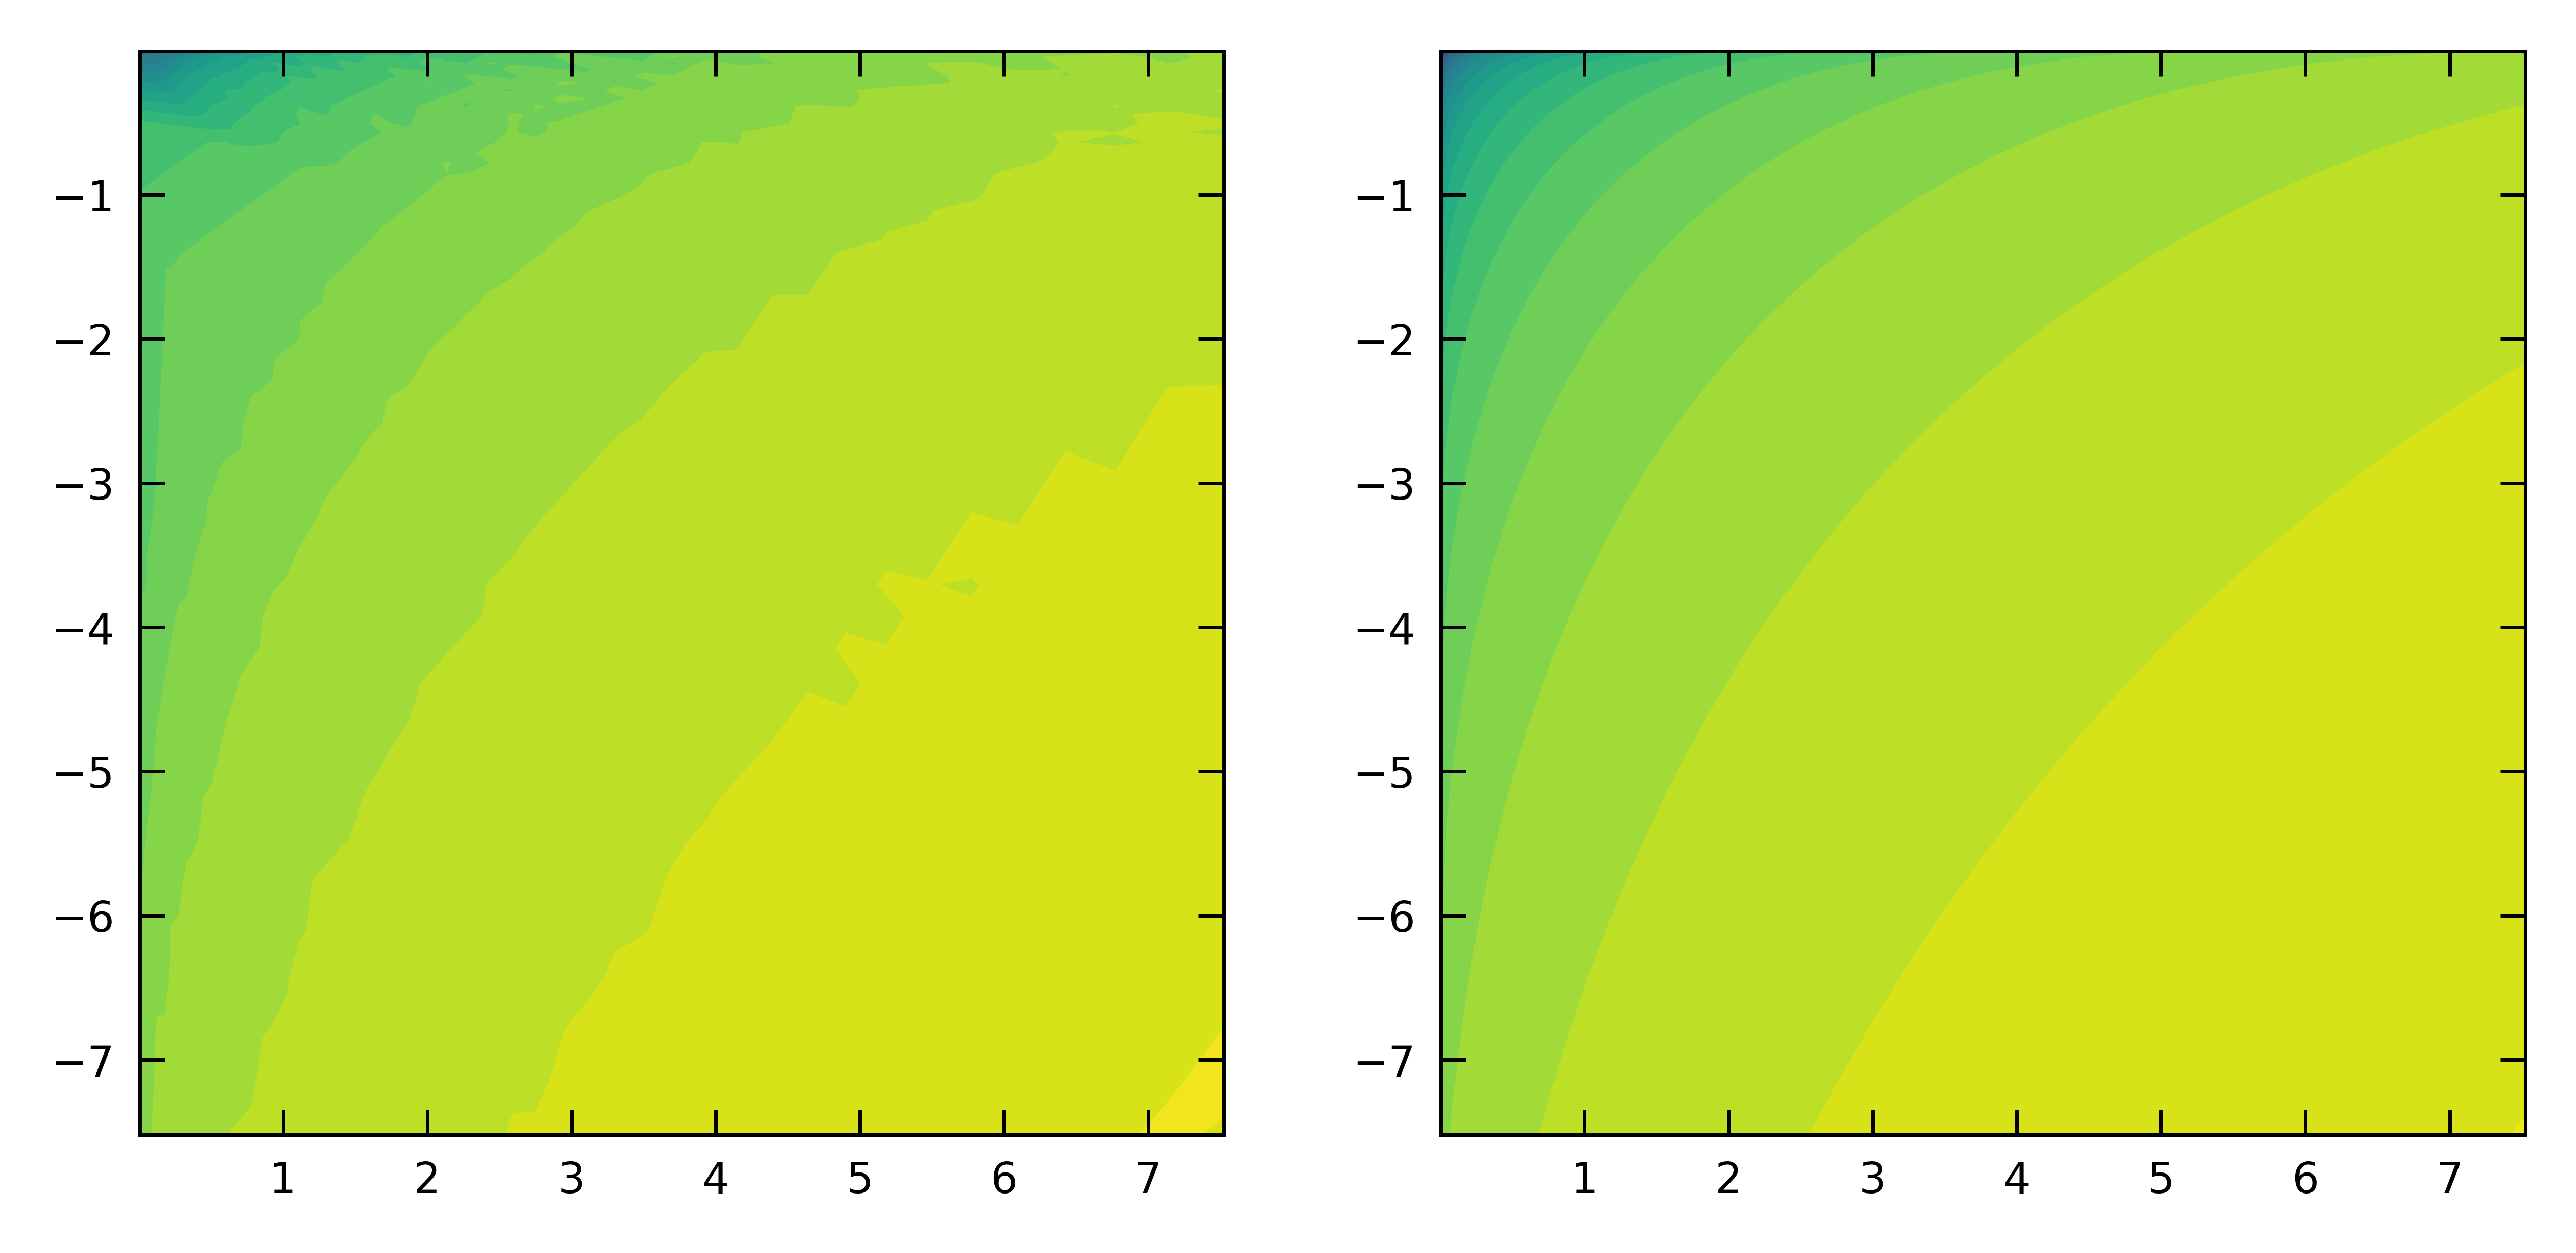

In [39]:
########################################################################
# data for results_4,5
##########################################################################
# create data used for symbolic regression
theta1_mesh, theta2_mesh, theta5_mesh = np.meshgrid(t1_stencil_log,
                                                    t2_stencil_log,
                                                    t5_stencil_log)
theta_table = np.concatenate(
    (theta1_mesh.reshape(
        -1, 1), theta2_mesh.reshape(-1, 1), np.zeros_like(theta2_mesh).reshape(
            -1, 1), np.zeros_like(theta2_mesh).reshape(-1, 1),
     theta5_mesh.reshape(-1, 1), np.zeros_like(theta2_mesh).reshape(-1, 1)),
    axis=1)

data = np.concatenate(
    (theta_table[:, [0, 1]], g1_nn(theta_table).reshape(-1, 1)), axis=1)
np.random.shuffle(data)
print(np.shape(data))
np.savetxt('aifeynman/sample/sample-data.dat', data)

g1_by_Shih = g1_Shih(theta1_mesh[:, :, 0], theta2_mesh[:, :, 0])
g1_by_nn = g1_nn(theta_table).reshape(50, 50, 50)
# find theta5 that best fits Shih
# id = np.zeros_like(theta5_mesh[:, :, 0], dtype=int)
g1_by_nn_best = np.zeros_like(theta5_mesh[:, :, 0])
for i in range(len(t1_stencil_log)):
    for j in range(len(t2_stencil_log)):
        id = np.argmin(np.abs(g1_by_nn[i, j, :] - g1_by_Shih[i, j]))
        g1_by_nn_best[i, j] = g1_by_nn[i, j, id]

# check if data is right
# for
print('nn,   min, max', g1_by_nn_best.min(), g1_by_nn_best.max())
print('shih, min, max', g1_by_Shih.min(), g1_by_Shih.max())
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
levels = np.linspace(-0.5, -0.06, 26)
ax[0].contourf(theta1_mesh[:, :, 0],
               theta2_mesh[:, :, 0],
               g1_by_nn_best,
               levels=levels)
ax[1].contourf(theta1_mesh[:, :, 0],
               theta2_mesh[:, :, 0],
               g1_by_Shih,
               levels=levels)
for i in range(2):
    ax[i].set(aspect='equal')
plt.savefig('check-3.png')

In [4]:
import aifeynman
import os
# do symbolic regression
# create data used for symbolic regression
theta_range = np.loadtxt(f'theta-range-{sampleId}.csv', delimiter=',')
t1 = np.linspace(theta_range[0, 0] + 2.5, theta_range[0, 1], 2500)
# # data for results_3
theta_table = np.concatenate(
    (t1.reshape(-1, 1), -t1.reshape(-1, 1), np.zeros_like(t1).reshape(
        -1, 1), np.zeros_like(t1).reshape(-1, 1),
     (-np.power(t1, 2) / 2).reshape(-1, 1), np.zeros_like(t1).reshape(-1, 1)),
    axis=1)

data = np.concatenate(
    (theta_table[:, [0]], g1_SHIH(theta_table).reshape(-1, 1)), axis=1)

# add noise on output data
print(np.shape(data))
np.savetxt('aifeynman/sample/sample-data.dat', data)

os.chdir(os.path.join(os.getcwd(), 'aifeynman'))
aifeynman.run_aifeynman(
    './sample/',
    'sample-data.dat',
    480,  #480,
    '14ops.txt',
    polyfit_deg=4,
    NN_epochs=1000,  #500,
    vars_name=['x1', 'g1'],
    test_percentage=15)
os.chdir('../')

(2500, 2)
Checking for brute force + 

Trying to solve mysteries with brute force...
Trying to solve ./sample/sample-data.dat_train
Rejection threshold.....    10.000
Bit margin..............     0.000
Number of variables.....       1
Functions used..........        +*-/><~\RPSCLE
 Arity            0 : Pa
 Arity            1 : ><~\RSCLE
 Arity            2 : +*-/
Loading mystery data....
        2125  rows read from file mystery.dat                                                                                                                                                                                                                                                     
Number of examples......    2125
Shuffling mystery data..
 Searching for best fit...
     22.881915762408     -3.233424198974                      P               1             0.0000         48624.0710             0.0125             0.0294             1.5519          2125.0000
     22.881915762408     -0.41014133528